In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return pd.Series(result)

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return pd.Series(result)

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin,xmax])
    print(type(xl))
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:243: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_8156\1214479212.py:235: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_8156\1214479212.py:238: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_8156\1214479212.py:240: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

[  271.6 10884.4]
k, b = $0.1247 \pm 0.0043$ $4289 \pm 24$


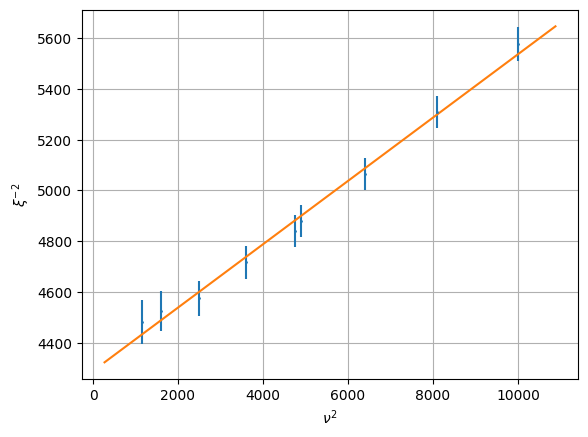

In [46]:
sigma = DData(5, E=7)
h = DData(1.5,E=-3)
d= DData(45,E=-3)
mu0 = DData(4*3.14,E=-7)
data1 = pd.read_csv("data1.csv")
data1["v"] = data1["v"].apply(lambda x: DData(x))
data1["U"] = data1["U"].apply(lambda x: DData(x,0.1, E=-3))
data1["I"] = data1["I"].apply(lambda x: DData(x,0.1, E=-3))
data1["E"] = data1["U"]/data1["v"]/data1["I"]
DData.changeEInSerias(data1["E"],0)
data1_srez = data1[data1["v"]>30]
data1_srez.index = range(len(data1_srez))
k1, b1 = linearcalc_error(data1_srez["v"]**2, data1_srez["E"]**-2)
plt.xlabel("$\\nu^2$")
plt.ylabel("$\\xi^{-2}$")
plt.savefig("fig_1.png", dpi=300)


In [47]:
B = (k1/b1)**0.5
sigma_1 = B/3.14/h/mu0/d*2
sigma_1.E=7

eps0 = b1**0.5

print(sigma_1,eps0)

$4.051 \pm 0.071$ $65.49 \pm 0.18$


In [48]:
data2 = pd.read_csv("data2.csv")
data2["v"] = data2["v"].apply(lambda x: DData(x))
data2["U"] = data2["U"].apply(lambda x: DData(x,0.1, E=-3))
data2["I"] = data2["I"].apply(lambda x: DData(x,0.1, E=-3))
data2["tdiv"] = data2["tdiv"].apply(lambda x: DData(x, E=-3))
data2["div"] = data2["div"].apply(lambda x: DData(x,0.1))
data2["phi"] = data2["tdiv"]*data2["div"]*data2["v"]*2*3.14 - 1*3.14/2
DData.changeEInSerias(data2["phi"],0)
#tdiv в мс

data2.head()

,v,U,I,div,tdiv,phi
0,$100.0 \pm 0.0$,$560.40 \pm 0.10$,$413.09 \pm 0.10$,$3.40 \pm 0.10$,$1.0 \pm 0.0$,$0.565 \pm 0.063$
1,$110.0 \pm 0.0$,$611.60 \pm 0.10$,$399.05 \pm 0.10$,$3.20 \pm 0.10$,$1.0 \pm 0.0$,$0.641 \pm 0.069$
2,$120.0 \pm 0.0$,$615.80 \pm 0.10$,$398.85 \pm 0.10$,$2.90 \pm 0.10$,$1.0 \pm 0.0$,$0.615 \pm 0.075$
3,$130.0 \pm 0.0$,$639.30 \pm 0.10$,$392.98 \pm 0.10$,$2.80 \pm 0.10$,$1.0 \pm 0.0$,$0.716 \pm 0.082$
4,$150.0 \pm 0.0$,$678.20 \pm 0.10$,$382.41 \pm 0.10$,$2.40 \pm 0.10$,$1.0 \pm 0.0$,$0.691 \pm 0.094$


<class 'numpy.ndarray'>
k, b = $0.00798 \pm 0.00028$ $-0.286 \pm 0.074$
$5.99 \pm 0.21$


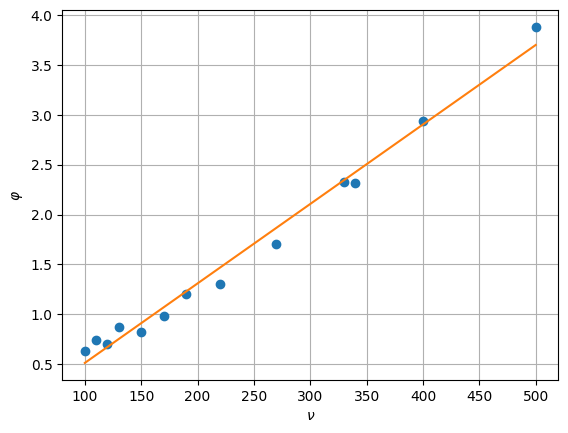

In [49]:
data2_srez = data2[data2["v"]<600]
k2,b2 = linearcalc(data2_srez["v"], np.tan(get_values(data2_srez["phi"])))
sigma_2 = k2/3.14/h/mu0/d*2
sigma_2.E=7
print(sigma_2)
plt.xlabel("$\\nu$")
plt.ylabel("$\\varphi$")
plt.savefig("fig_2.png",dpi=300)

<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_8156\4027337260.py:8: SyntaxWarning: invalid escape sequence '\P'
  plt.ylabel("$\\varphi-\\frac{\Pi}{4}$")


[ 46.81996277 184.69463694]
k, b = $0.02003 \pm 0.00054$ $-0.034 \pm 0.060$
$4.52 \pm 0.24$


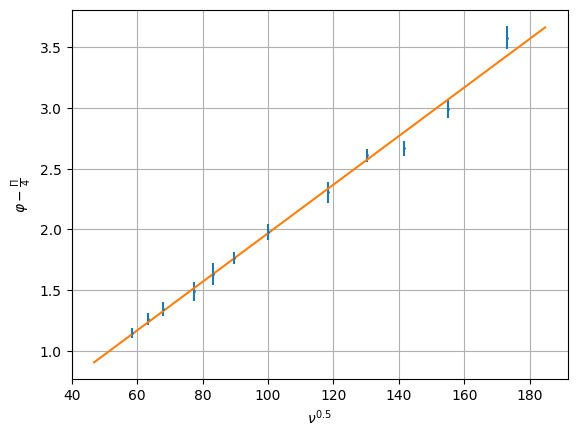

In [84]:
data2_srez = data2[data2["v"]<100000][data2["v"]>3000]
data2_srez.index = range(len(data2_srez))
k3,b3 = linearcalc_error(data2_srez["v"]**0.5, (data2_srez["phi"]) - 3.14/4)
sigma_3 = (k3/h)**2/3.14/mu0
sigma_3.E=7
print(sigma_3)  
plt.xlabel("$\\nu^{0.5}$")
plt.ylabel("$\\varphi-\\frac{\Pi}{4}$")
plt.savefig("fig_3.png",dpi=300)


<class 'numpy.ndarray'>
k, b = $0.00002550 \pm 0.00000067$ $1.37 \pm 0.26$
$3.794 \pm 0.050$


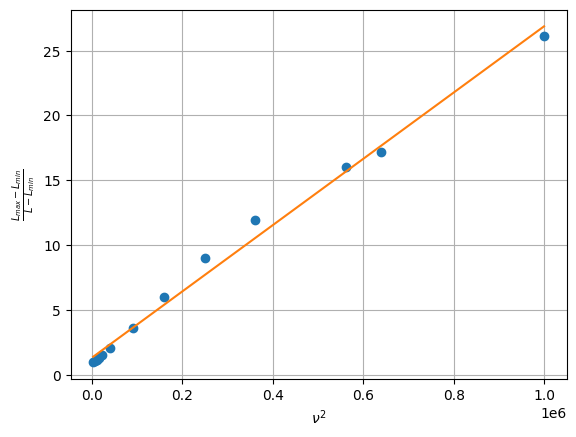

In [51]:
data3 = pd.read_csv("data3.csv")
data3 = data3.sort_values("v")
data3.index = range(len(data3))
data3["e"] = (9.9-2.85)/(data3["L"]-2.85)
data3_srez = data3[data3["v"]<1500]
k4,b4 = linearcalc(data3_srez["v"]**2,data3_srez["e"])
sigma_4 = k4**0.5/3.14/d*2/mu0/h
sigma_4.E=7
print(sigma_4)
data3
plt.xlabel("$\\nu^{2}$")
plt.ylabel("$\\frac{L_{max}-L_{min}}{L-L_{min}}$")
plt.savefig("fig_4.png",dpi=300)

In [52]:
ultra = pd.DataFrame()
ultra["v"] = pd.Series(list(data1["v"])+list(data2["v"]))
ultra["U"]= pd.Series(list(data1["U"])+list(data2["U"]))
ultra["I"] = pd.Series(list(data1["I"])+list(data2["I"]))
ultra["k"] =  ultra["U"]*ultra["v"]**-1*ultra["I"]**-1 * eps0

ultra

,v,U,I,k
0,$20.0 \pm 0.0$,$6.50 \pm 0.10$,$22.55 \pm 0.10$,$0.944 \pm 0.015$
1,$25.0 \pm 0.0$,$8.30 \pm 0.10$,$22.54 \pm 0.10$,$0.965 \pm 0.013$
2,$30.0 \pm 0.0$,$10.10 \pm 0.10$,$22.50 \pm 0.10$,$0.980 \pm 0.011$
3,$34.0 \pm 0.0$,$11.40 \pm 0.10$,$22.45 \pm 0.10$,$0.978 \pm 0.010$
4,$40.0 \pm 0.0$,$13.30 \pm 0.10$,$22.36 \pm 0.10$,$0.9737 \pm 0.0089$
5,$50.0 \pm 0.0$,$16.40 \pm 0.10$,$22.18 \pm 0.10$,$0.9683 \pm 0.0078$
6,$60.0 \pm 0.0$,$19.20 \pm 0.10$,$21.98 \pm 0.10$,$0.9535 \pm 0.0071$
7,$69.0 \pm 0.0$,$21.60 \pm 0.10$,$21.78 \pm 0.10$,$0.9414 \pm 0.0067$
8,$70.0 \pm 0.0$,$21.80 \pm 0.10$,$21.76 \pm 0.10$,$0.9374 \pm 0.0066$
9,$80.0 \pm 0.0$,$24.20 \pm 0.10$,$21.52 \pm 0.10$,$0.9204 \pm 0.0063$


In [53]:
k_d = sigma_1*mu0
k_d.E=0
h1 = h
h1.E = 0
h1 = h1.value
d1 = d
d1.E = 0
d1 = d1.value
a_k_1 = (1j*get_values(ultra["v"])*2*3.14*k_d.value)**0.5
H_k = 1/(np.cosh(a_k_1*h1) + 0.25*a_k_1*d1*np.sinh(a_k_1*h1))
H_k = abs(H_k)


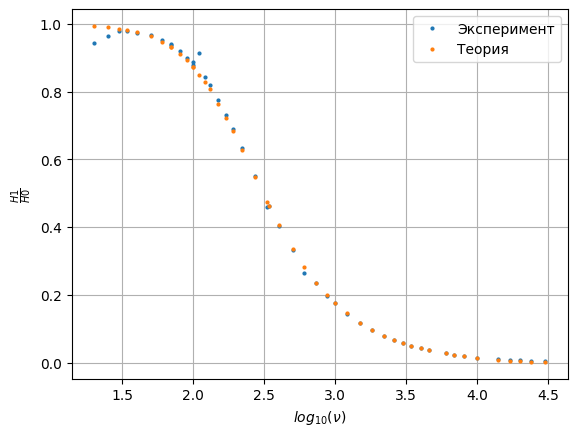

In [63]:
ultra_srez = ultra[ultra["v"]<600000]
plt.plot(np.log10(get_values(ultra_srez["v"])), get_values(ultra_srez["k"]),"o",ms=2, label = "Эксперимент")
plt.grid(True)
plt.plot(np.log10(get_values(ultra_srez["v"])), H_k,"o",ms=2, label = "Теория")
plt.xlabel("$log_{10}(\\nu)$")
plt.ylabel("$\\frac{H1}{H0}$")
plt.legend()
plt.savefig("fig_5.png", dpi=300)

In [72]:
data1_output = pd.DataFrame()
data1_output["$\\nu$, Гц"] = data1["v"]
data1_output["U, мВ"] = data1["U"]
data1_output["I, мА"] = data1["I"]
data1_output["$\\epsilon$"] = data1["E"]
data1_output.to_clipboard()
data1_output


,"$\nu$, Гц","U, мВ","I, мА",$\epsilon$
0,$20.0 \pm 0.0$,$6.50 \pm 0.10$,$22.55 \pm 0.10$,$0.01441 \pm 0.00023$
1,$25.0 \pm 0.0$,$8.30 \pm 0.10$,$22.54 \pm 0.10$,$0.01473 \pm 0.00019$
2,$30.0 \pm 0.0$,$10.10 \pm 0.10$,$22.50 \pm 0.10$,$0.01496 \pm 0.00016$
3,$34.0 \pm 0.0$,$11.40 \pm 0.10$,$22.45 \pm 0.10$,$0.01494 \pm 0.00015$
4,$40.0 \pm 0.0$,$13.30 \pm 0.10$,$22.36 \pm 0.10$,$0.01487 \pm 0.00013$
5,$50.0 \pm 0.0$,$16.40 \pm 0.10$,$22.18 \pm 0.10$,$0.01478 \pm 0.00011$
6,$60.0 \pm 0.0$,$19.20 \pm 0.10$,$21.98 \pm 0.10$,$0.01456 \pm 0.00010$
7,$69.0 \pm 0.0$,$21.60 \pm 0.10$,$21.78 \pm 0.10$,$0.014375 \pm 0.000094$
8,$70.0 \pm 0.0$,$21.80 \pm 0.10$,$21.76 \pm 0.10$,$0.014314 \pm 0.000093$
9,$80.0 \pm 0.0$,$24.20 \pm 0.10$,$21.52 \pm 0.10$,$0.014053 \pm 0.000087$


In [76]:
data2_output = pd.DataFrame()
data2_output["$\\nu$, Гц"] = data2["v"]
data2_output["U, мВ"] = data2["U"]
data2_output["I, мА"] = data2["I"]
data2_output["$\\varphi$"] = data2["phi"]
data2_output.to_clipboard()
data2_output

,"$\nu$, Гц","U, мВ","I, мА",$\varphi$
0,$100.0 \pm 0.0$,$560.40 \pm 0.10$,$413.09 \pm 0.10$,$0.565 \pm 0.063$
1,$110.0 \pm 0.0$,$611.60 \pm 0.10$,$399.05 \pm 0.10$,$0.641 \pm 0.069$
2,$120.0 \pm 0.0$,$615.80 \pm 0.10$,$398.85 \pm 0.10$,$0.615 \pm 0.075$
3,$130.0 \pm 0.0$,$639.30 \pm 0.10$,$392.98 \pm 0.10$,$0.716 \pm 0.082$
4,$150.0 \pm 0.0$,$678.20 \pm 0.10$,$382.41 \pm 0.10$,$0.691 \pm 0.094$
5,$170.0 \pm 0.0$,$708.30 \pm 0.10$,$373.42 \pm 0.10$,$0.779 \pm 0.053$
6,$190.0 \pm 0.0$,$731.70 \pm 0.10$,$365.80 \pm 0.10$,$0.876 \pm 0.060$
7,$220.0 \pm 0.0$,$757.10 \pm 0.10$,$356.39 \pm 0.10$,$0.917 \pm 0.069$
8,$270.0 \pm 0.0$,$783.10 \pm 0.10$,$344.73 \pm 0.10$,$1.041 \pm 0.034$
9,$330.0 \pm 0.0$,$799.30 \pm 0.10$,$344.81 \pm 0.10$,$1.166 \pm 0.041$


In [81]:
data3_output = pd.DataFrame()
data3_output["$\\nu$, Гц"] = data3["v"]
data3_output["R, Ом"] = data3["R"]
data3_output["L, мГн"] = data3["L"]
data3_output["$\\frac{L_{max}-L_{min}}{L-L_{min}}$"] = data3["e"]
data3_output.to_clipboard()
data3_output

,"$\nu$, Гц","R, Ом","L, мГн",$\frac{L_{max}-L_{min}}{L-L_{min}}$
0,50,19.47,9.88,1.002845
1,75,20.14,9.35,1.084615
2,100,20.98,8.71,1.203072
3,120,21.59,8.12,1.337761
4,150,22.39,7.35,1.566667
5,200,23.63,6.22,2.091988
6,300,25.10,4.79,3.634021
7,400,25.74,4.02,6.025641
8,500,26.37,3.63,9.038462
9,600,26.88,3.44,11.949153


In [82]:
print(sigma_1,sigma_2,sigma_3,sigma_4)

$4.051 \pm 0.071$ $5.99 \pm 0.21$ $4.17 \pm 0.32$ $3.794 \pm 0.050$
